# Organizing data into a data pipeline with DataJoint

Here we are going to take a very quick look at how you can create, organize, and even run computations inside a **data pipeline** built using a Python (and MATLAB) package called **DataJoint**.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### NOTE

This notebook is kept intentionally succinct and a lot of details about DataJoint is explained only minimally. Interested students who wish to learn more about DataJoint are referred to the [tutorials](https://tutorials.datajoint.io) as well as on [DataJoint two-days workshop](https://github.com/datajoint/neuronex_workshop_2018) with accompanying videos.

Once you have successfully installed DataJoint, you can go ahead and import the package just like for NumPy and Matplotlib. The convention is to import `datajoint as dj`.

In [4]:
import datajoint as dj
from getpass import getpass

In [9]:
dj.config['database.user'] = 'shanshen' # be sure to replace this with your username
dj.config['database.host'] = 'tutorial-db.datajoint.io'
dj.config['database.password'] = getpass('Enter your password: ')

In [10]:
dj.conn()

Connecting shanshen@tutorial-db.datajoint.io:3306


DataJoint connection (connected) shanshen@tutorial-db.datajoint.io:3306

# So... What is a data pipeline?

A data pipeline is a listing or a "map" of various "things" that you work with in a project, with line connecting things to each other to indicate their dependecies. The "things" may include anything from mouse, experimenter, equipment, to experiment session, trial, two-photon scans, electric activities, to receptive fields, neuronal spikes, to figures for a publication! 


A data pipeline gives you a framework to:

1. define these "things" as tables in which you can store the information about them
2. define the relationships (in particular the dependencies) between the "things"

Let's go ahead and build together a pipeline from scratch to better understand what a data pipeline is all about.

# Building our first pipeline: single electrode recording from mouse

Let's build a pipeline to collect, store and process data and analysis for our hypothetical single electrode recording study in mice. To help us understand the project better, here is a brief description:

> * Your lab houses many **mice**, and each mouse is identified by a unique ID. You also want to keep track of information about each mouse such as their date of birth and gender.
> * As a hard working neuroscientist, you perform experiments every day, sometimes working with more than one mouse in a day! However, on an any given day, a mouse undergoes at most one recording session.
> * For each **experimental session**, you would like to record what mouse you worked with and when you performed the experiment. You would also like to keep track of other helpful information such as the experimental setup you worked on.
> * In each **experimental session**, you record electrical activity from **a single neuron**. You use recording equipment that produces separate data files for each neuron you recorded.
> * Neuron's activities are recorded as raw traces. **Neuron's spikes** needs to be detected for further analysis to be performed.

Just by going though the description, we can start to identify **things** that we might want to store and represent in our data pipeline:

* mouse
* experimental session
* neuron
* spikes

In DataJoint data pipeline, we represent these **things** as **tables**. Different *kinds* of entities become distinct tables, and each row of the table is a single example (instance) of the category of entity. 

For example, if we have a `Mouse` table, then each row in the mouse table represents a single mouse!

When constructing such table, we need to figure out what it would take to **uniquely identify** each entry. For example, in constructing a table for mice, we might conclude that each mouse can be uniquely identified by knowing its **mouse ID** - a unique ID number assigned to each mouse in the lab. The mouse ID is then a column in the table or an **attribute** that can be used to **uniquely identify** each mouse. Such attribute is called the **primary key** of the table.

| mouse_id* |
|:--------:|
| 11234    |
| 11432    |

Once we have successfully identified the primary key of the table, we can now think about what other columns, or **non-primary key attributes** that we would want to include in the table. These are additional information **about each entry in the table that we want to store**.

For the case of mouse, what other information about the mouse you might want to store? Based on the project description, we would probably want to store information such as the mouse's **date of birth** and **gender**.

| mouse_id* | dob        | sex |
|:--------:|------------|--------|
| 11234    | 2017-11-17 | M      |
| 11432    | 2018-03-04 | F      |

Now we have an idea on how to represent information about mouse, let's create the table using **DataJoint**!

# Creating Mouse table

One or more tables can be grouped together into a **schema**, allowing you to keep related entities together for conceptual clarity.

In [11]:
schema = dj.schema('{}_pipeline'.format(dj.config['database.user']))

In [12]:
schema

Schema database: `shanshen_pipeline`

In DataJoint, you define each table as a class, and provide the table definition (e.g. attribute definitions) as the `definition` string property. The class will inherit from the `dj.Manual` class provided by DataJoint.

In [13]:
@schema
class Mouse(dj.Manual):
    definition = """
    # Experimental animals
    mouse_id             : int                          # Unique animal ID
    ---
    dob=null             : date                         # date of birth
    sex="unknown"        : enum('M','F','unknown')      # sex
    """

Let's take a look at our brand new table

In [14]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
1,2016-11-19,M
2,2016-11-20,unknown
5,2016-12-25,F
10,2017-01-01,F
11,2017-01-03,F
100,2017-05-12,F


Once created you can **insert** data into the table. Below I insert information about multiple mice, using various methods of insertion:

In [15]:
# insert one a time
Mouse.insert1((0, '2017-03-01', 'M'))

DataJointError: Duplicate entry '0' for key 'PRIMARY' : To ignore duplicate entries, set skip_duplicates=True in insert.

In [16]:
# or insert in batches
data = [
  (1, '2016-11-19', 'M'),
  (2, '2016-11-20', 'unknown'),
  (5, '2016-12-25', 'F')
]

# now insert all at once
Mouse.insert(data)

DataJointError: Duplicate entry '1' for key 'PRIMARY' : To ignore duplicate entries, set skip_duplicates=True in insert.

In [17]:
# inserting as dictionary
data = {
    'mouse_id': 100,
    'dob': '2017-05-12',
    'sex': 'F'
}

Mouse.insert1(data)

DataJointError: Duplicate entry '100' for key 'PRIMARY' : To ignore duplicate entries, set skip_duplicates=True in insert.

In [18]:
# inserting list of dictionaries

data = [
  {'mouse_id': 10, 'dob': '2017-01-01', 'sex': 'F'},
  {'mouse_id': 11, 'dob': '2017-01-03', 'sex': 'F'},
]

# insert them all
Mouse.insert(data)

DataJointError: Duplicate entry '10' for key 'PRIMARY' : To ignore duplicate entries, set skip_duplicates=True in insert.

We now have multilpe mice in our table!

In [19]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
1,2016-11-19,M
2,2016-11-20,unknown
5,2016-12-25,F
10,2017-01-01,F
11,2017-01-03,F
100,2017-05-12,F


## Data integrity

DataJoint checks for data integrity, and ensures that you don't insert a duplicate by mistake. When you try to insert an **already existing mouse**, DataJoint will trigger an error!

In [20]:
Mouse.insert1(
{'mouse_id': 0,
 'dob': '2018-01-01',
 'sex': 'M',
})

DataJointError: Duplicate entry '0' for key 'PRIMARY' : To ignore duplicate entries, set skip_duplicates=True in insert.

## Fetching all data

Of course, information contained in the table can be **fetched** easily for you to work with:

In [21]:
data = Mouse.fetch() # get all mouse!!
data

array([(  0, datetime.date(2017, 3, 1), 'M'),
       (  1, datetime.date(2016, 11, 19), 'M'),
       (  2, datetime.date(2016, 11, 20), 'unknown'),
       (  5, datetime.date(2016, 12, 25), 'F'),
       ( 10, datetime.date(2017, 1, 1), 'F'),
       ( 11, datetime.date(2017, 1, 3), 'F'),
       (100, datetime.date(2017, 5, 12), 'F')],
      dtype=[('mouse_id', '<i8'), ('dob', 'O'), ('sex', 'O')])

You can also get specific attributes at a time!

In [22]:
# only get the sex of all mouse
Mouse.fetch('sex')

array(['M', 'M', 'unknown', 'F', 'F', 'F', 'F'], dtype=object)

# DataJoint query language

DataJoint offers very powerful yet intuitive **querying** syntax that let's you select exactly the data you want before you fetch it.

## Restricting by attribute value

The **restriction** operation, `&`, let's you specify the criteria to narrow down the table on the left.

All male mice (`sex = "M"'`)

In [23]:
Mouse & 'sex = "M"'

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
1,2016-11-19,M


Mouse that is born **after 2017-01-01**

In [24]:
Mouse & 'dob > "2017-01-01"'

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
11,2017-01-03,F
100,2017-05-12,F


You can easily combine multiple restrictions to narrow down the entities based on multiple attributes.

Let's find all mouse that **is not male** AND **born after 2017-01-01**.

In [25]:
Mouse & 'sex != "M"' & 'dob > "2017-01-01"'

mouse_id Unique animal ID,dob date of birth,sex sex
11,2017-01-03,F
100,2017-05-12,F


In fact you can **build up query** by chaining together query results

In [26]:
female_mice = Mouse & 'sex = "F"'
female_mice

mouse_id Unique animal ID,dob date of birth,sex sex
5,2016-12-25,F
10,2017-01-01,F
11,2017-01-03,F
100,2017-05-12,F


and among these mice, find ones with birthday after  "2017-01-02"

In [27]:
female_mice & 'dob > "2017-01-02"'

mouse_id Unique animal ID,dob date of birth,sex sex
11,2017-01-03,F
100,2017-05-12,F


## Fetch query results

Once you have successfully narrowed down to the entities you want, you can fetch the query results just by calling fetch on it!

All male mouse

In [28]:
male_mouse = Mouse & 'sex = "M"'
male_mouse

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
1,2016-11-19,M


Fetch it!

In [29]:
male_mouse.fetch()

array([(0, datetime.date(2017, 3, 1), 'M'),
       (1, datetime.date(2016, 11, 19), 'M')],
      dtype=[('mouse_id', '<i8'), ('dob', 'O'), ('sex', 'O')])

or all in one step

In [30]:
(Mouse & 'sex = "M"').fetch()

array([(0, datetime.date(2017, 3, 1), 'M'),
       (1, datetime.date(2016, 11, 19), 'M')],
      dtype=[('mouse_id', '<i8'), ('dob', 'O'), ('sex', 'O')])

# Building pipeline with dependencies

Let's now take a look at representing an **experimental session**.

As with mouse, we should think about **what information (i.e. attributes) is needed to uniquely identify an experimental session**. Here is the relevant section of the project description:

> * As a hard working neuroscientist, you perform experiments every day, sometimes working with **more than one mouse in a day**! However, on an any given day, **a mouse undergoes at most one recording session**.
> * For each experimental session, you would like to record **what mouse you worked with** and **when you performed the experiment**. You would also like to keep track of other helpful information such as the **experimental setup** you worked on.

Based on the above, it appears that you need to know:

* the date of the session
* the mouse you recorded from in that session

to uniquely identify a single experimental session.

Note that, to uniquely identify an experimental session (or simply a **session**), we need to know the mouse that the session was about. In other words, a session cannot existing without a corresponding mouse! 

With **mouse** already represented as a table in our pipeline, we say that the session **depends on** the mouse! We would graphically represent this in an **entity relationship diagram (ERD)** by drawing the line between two tables, with the one below (**session**) dependeing on the one above (**mouse**).

![mouse_sessions](images/mouse_session.svg)

In DataJoint, you declare that **session** depends on the mouse, and you specify any additional attribute(s) necessary to uniquely identify a session, such as the **session date**.

In [31]:
@schema
class Session(dj.Manual):
    definition = """
    # Experiment session
    -> Mouse
    session_date               : date                         # date
    ---
    experiment_setup           : int                          # experiment setup ID
    experimenter               : varchar(100)                 # experimenter name
    """

You can visualize the dependencies of entities (tables) you defined so far by calling `dj.ERD` function:

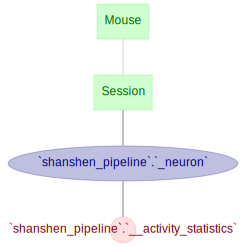

In [32]:
dj.ERD(schema)

Below we insert a multiple sessions.

In [33]:
# session for mouse_id=0
data = {
  'mouse_id': 0,
  'session_date': '2017-05-15',
  'experiment_setup': 0,
  'experimenter': 'Edgar Y. Walker'
}

Session.insert1(data)

DataJointError: Duplicate entry '0-2017-05-15' for key 'PRIMARY' : To ignore duplicate entries, set skip_duplicates=True in insert.

In [34]:
# another session for mouse_id=0 but on a different date
data = {
  'mouse_id': 0,
  'session_date': '2017-05-19',
  'experiment_setup': 100,
  'experimenter': 'Jacob Reimer'
}

# insert them all
Session.insert1(data)

DataJointError: Duplicate entry '0-2017-05-19' for key 'PRIMARY' : To ignore duplicate entries, set skip_duplicates=True in insert.

In [35]:
# another session done on a different mouse
data = {
  'mouse_id': 5,
  'session_date': '2017-01-05',
  'experiment_setup': 101,
  'experimenter': 'Jacob Reimer'
}

# insert them all
Session.insert1(data)

DataJointError: Duplicate entry '5-2017-01-05' for key 'PRIMARY' : To ignore duplicate entries, set skip_duplicates=True in insert.

In [36]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name
0,2017-05-15,0,Edgar Y. Walker
0,2017-05-19,100,Jacob Reimer
5,2017-01-05,101,Jacob Reimer


Trying to add information (e.g. a session) for a mouse that doesn't exist will trigger an error!

In [37]:
bad_data = {
    'mouse_id': 9999,  # this mouse doesn't exist!
    'session_date': '2017-05-15',
    'experiment_setup': 0,
    'experimenter': 'Edgar Y. Walker'
}

In [38]:
Session.insert1(bad_data)

IntegrityError: (1452, 'Cannot add or update a child row: a foreign key constraint fails (`shanshen_pipeline`.`session`, CONSTRAINT `session_ibfk_1` FOREIGN KEY (`mouse_id`) REFERENCES `mouse` (`mouse_id`) ON UPDATE CASCADE)')

# Querying with multiple tables

Now we have two tables, we can perform more exciting queries!

All mouse that has a session

In [39]:
Mouse & Session

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
5,2016-12-25,F


Find sessions performed on a male mouse

In [40]:
Session & (Mouse & 'sex = "M"')

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name
0,2017-05-15,0,Edgar Y. Walker
0,2017-05-19,100,Jacob Reimer


Sometimes you want to see information from multiple tables combined together to be viewed (and queried!) simultaneously. You can do this using the join `*` operator.

In [41]:
Mouse * Session

mouse_id Unique animal ID,session_date date,dob date of birth,sex sex,experiment_setup experiment setup ID,experimenter experimenter name
0,2017-05-15,2017-03-01,M,0,Edgar Y. Walker
0,2017-05-19,2017-03-01,M,100,Jacob Reimer
5,2017-01-05,2016-12-25,F,101,Jacob Reimer


# Importing data from data files

Recall from the project description
> * In each experimental session, you record electrical activity from a single neuron. You use recording equipment that produces separate data files for each neuron you recorded.

Our recording equipment produces a data file for each neuron recorded. Since we record from one neuron per session, there should be one data file for each session.

In the `data` directory, you will find `.npy` (saved NumPy array) files with names like `data_100_2017-05-25.npy`.

As you might have guessed, these are the data for the recording sessions in the `Session` table, and each file are named according to the `mouse_id` and `session_date` - the attributes of the primary keys - in the format `data_{mouse_id}_{session_date}.npy`.

So `data_100_2017-05-25.npy` is the data for session identified by `mouse_id = 100` and `session_date = "2017-05-25"`.

## Looking at the data 

Let's take a quick peak at the data file content.

In [42]:
data = np.load('data/data_0_2017-05-15.npy')

Look at its content...

In [43]:
data

array([ 3.57887412e-01,  4.47531558e-01,  1.96412988e-01,  3.91114491e-01,
        1.76695176e-01,  3.80088116e-01,  9.36353656e-02,  1.10668001e-02,
        1.14509759e-01,  1.65947705e-01,  1.02058476e-01,  1.15037690e-01,
        2.18115225e-01,  1.34076355e-01,  7.74560696e-02,  9.19639027e-02,
       -7.60109670e-03,  1.12814011e+00,  9.48711628e-01,  7.77781245e-01,
        5.46847747e-01,  3.91930226e-01,  2.19542222e-01,  3.92001858e-01,
        3.17729202e-01,  2.97934834e-01,  1.85589403e-01,  3.04215179e-01,
        8.75626287e-02, -1.76018214e-02,  1.43719730e-01, -1.28348781e-01,
       -4.38344653e-02,  1.57370375e-01,  1.70233992e-01,  8.98556797e-01,
        9.36896773e-01,  1.67418776e+00,  2.48160598e+00,  1.89737445e+00,
        1.45746470e+00,  1.32137967e+00,  1.05349900e+00,  1.88503636e+00,
        1.53324759e+00,  1.34566597e+00,  1.93924029e+00,  1.58839106e+00,
        1.26074176e+00,  1.21973014e+00,  9.80495008e-01,  7.66163859e-01,
        1.59531686e+00,  

...and check the shape of the data.

In [44]:
data.shape

(1000,)

So this particular file contains a NumPy array of length 1000. This represents a (simulated) recording of raw electric activity from a single neuron over 1000 time bins.

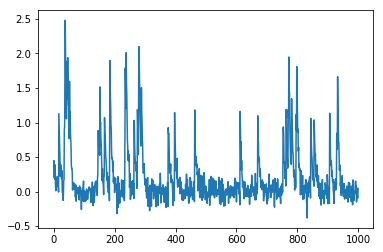

In [45]:
plt.plot(data)

## Defining the table for recorded neurons

We now would like to have all these recorded `Neuron` represented and stored in our data pipeline.

Since we only record a single neuron from each session, a `Neuron` can be uniquely identified by knowing the `Session` it was recorded in. For each `Neuron`, we want to store the neural activity found in the data file.

In [46]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    ---
    activity: longblob    # electric activity of the neuron
    """

Let's check the state of our pipeline.

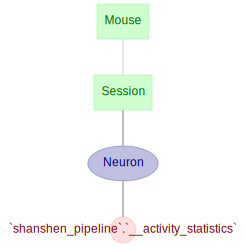

In [47]:
dj.ERD(schema)

We defined `activity` as a `longblob` so that it can store a NumPy array holding the electric activity over time. This NumPy array will be imported from the file corresponding to each neuron.

Note that our `Neuron` class inherits from `dj.Imported` instaed of `dj.Manual` like others. This is because **this table's content will depend on data imported from an external file**. The `Manual` vs `Imported` are said to specify the **tier of the table**.

## Automatically importing data for all sessions

Because `Neuron` depends on `Session`, it understands that there may be a `Neuron` per `Session`. Using this information, DataJoint can trigger importing of a `Neuron`'s data from the data file **for each entry in the `Session`**.

We define how to **load a Neuron's information for each Session** inside a special method called `make`:

In [48]:
@schema
class Neuron(dj.Imported):
    definition = """
    -> Session
    ---
    activity: longblob    # electric activity of the neuron
    """
    def make(self, key):
        # key points to a single entry in the Session table
        
        # use key dictionary to determine the data file path
        data_file = "data/data_{mouse_id}_{session_date}.npy".format(**key)

        data = np.load(data_file)

        # add the loaded data as the "activity" column
        key['activity'] = data

        # insert the key into self
        self.insert1(key)

        print('Populated a neuron for mouse_id={mouse_id} on session_date={session_date}'.format(**key))

Now you can **trigger `make` to be run for all `Session`** by simply calling `populate` method!

In [49]:
Neuron.populate()

In [50]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name
0,2017-05-15,0,Edgar Y. Walker
0,2017-05-19,100,Jacob Reimer
5,2017-01-05,101,Jacob Reimer


In [51]:
Neuron()

mouse_id Unique animal ID,session_date date,activity electric activity of the neuron
0,2017-05-15,=BLOB=
0,2017-05-19,=BLOB=
5,2017-01-05,=BLOB=


DataJoint has successfully discovered data for all three sessions and **populated** `Neuron` table with the content of the data files!

# Computations in data pipeline

Now we have successfully imported all data we have into our pipeline, it's time for us to start analyzing them! 

In DataJoint, you can also represent **things** you computed as entries in a table. Here the key is that you think more in terms of **what** rather than **how**!

Now, let's say that we want to compute the satististics, such as mean, standard deviation, and maximum value of each of our neuron's activity traces. Hence we want to compute the neuron's **activity statistics** for each neuron!

So the new "thing" or entity here is `ActivityStatistics`, where each entry corresponds to the statistics of a single `Neuron`. Let's start designing the table, paying special attention to the dependencies.

### Statistics of neuron activities

Let's go ahead and work out the definition of the table.

In [52]:
@schema
class ActivityStatistics(dj.Computed):
    definition = """
    -> Neuron
    ---
    mean: float    # mean activity
    stdev: float   # standard deviation of activity
    max: float     # maximum activity
    """

Did you notice that we are now inheriting from `dj.Computed`?  `Computed` is yet another table tier that signifies that **the entries of this table are computed using data in other tables**. `Computed` tables are represented as red circles in the ERD.

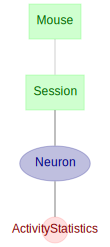

In [53]:
dj.ERD(schema)

Just like the `Imported` tables, `Computed` tables make use of the same `make` and `populate` logic for defining new entries in the table. Let's go ahead and implement `make` method.

In [54]:
@schema
class ActivityStatistics(dj.Computed):
    definition = """
    -> Neuron
    ---
    mean: float    # mean activity
    stdev: float   # standard deviation of activity
    max: float     # maximum activity
    """
    
    def make(self, key):
        # each key corresponds to a Neuron
        
        # get the activity data for the specific neuron
        activity = (Neuron() & key).fetch1('activity') 

        # compute various statistics on activity
        key['mean'] = activity.mean()   # compute mean
        key['stdev'] = activity.std()   # compute standard deviation
        key['max'] = activity.max()     # compute max
        self.insert1(key)
        print('Computed statistics for mouse_id {mouse_id} session_date {session_date}'.format(**key))

Let's go ahead and populate the table.

In [55]:
ActivityStatistics.populate()

In [56]:
ActivityStatistics()

mouse_id Unique animal ID,session_date date,mean mean activity,stdev standard deviation of activity,max maximum activity
0,2017-05-15,0.207357,0.400867,2.48161
0,2017-05-19,0.13274,0.291462,1.82805
5,2017-01-05,0.0891786,0.236412,1.37389


Voila!! You have computed statistics for each neuron activity!

# Spike detection (Bonus)

Using a similar mechanism, we can implement `Spikes` table that performs rudimentary **spike detection** on the data found in the `Neuron`'s activity.

In [57]:
# special syntax to get only the primary keys for all entries
keys = Neuron.fetch('KEY')

In [58]:
# fetch all activities - returned as NumPy array of NumPy arrays
activities = (Neuron & keys).fetch('activity')

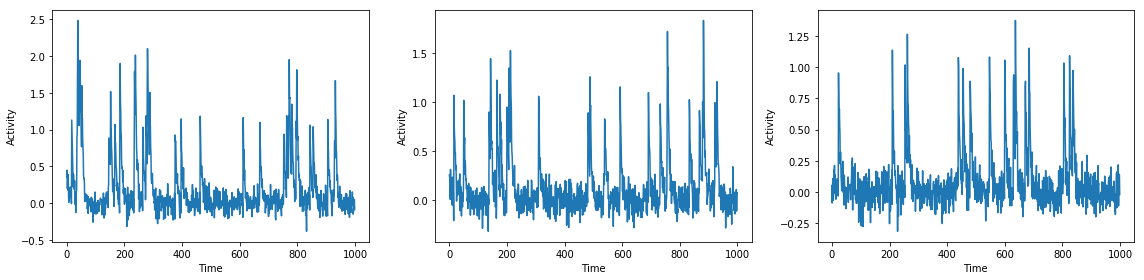

In [59]:
fig, axs = plt.subplots(1, len(activities), figsize=(16, 4))
for activity, ax in zip(activities, axs.ravel()):
    ax.plot(activity)
    ax.set_xlabel('Time')
    ax.set_ylabel('Activity')

fig.tight_layout()

Let's now focus on one trace instead.

In [60]:
key = keys[0]

In [61]:
activity = (Neuron & key).fetch1('activity')

(0, 300)

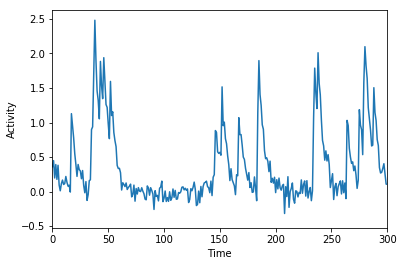

In [62]:
plt.plot(activity)
plt.xlabel('Time')
plt.ylabel('Activity')
plt.xlim([0, 300])

Perhaps we can use threshold to detect when a spike occurs. Threshold of `0.5` may be a good start.

(0, 300)

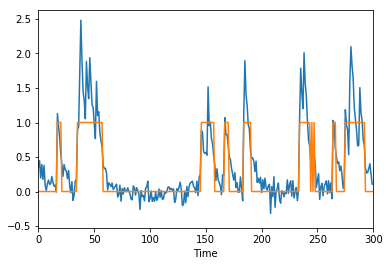

In [63]:
threshold = 0.5

# find activity above threshold
above_thrs = (activity > threshold).astype(np.int)   

plt.plot(activity)
plt.plot(above_thrs)
plt.xlabel('Time')
plt.xlim([0, 300])

We want to find out **when** it crossed the threshold. That is, find time bins where `above_thrs` goes from 0 (`False`) to 1 (`True`).

(0, 300)

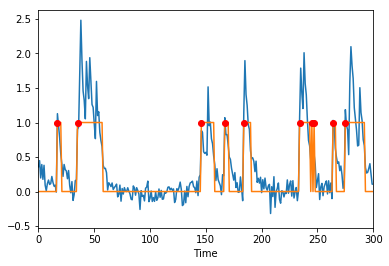

In [64]:
rising = (np.diff(above_thrs) > 0).astype(np.int)   # find rising edge of crossing threshold
spikes = np.hstack((0, rising))    # prepend 0 to account for shortening due to np.diff

plt.plot(activity)
plt.plot(above_thrs)
plt.plot(np.where(spikes>0), 1,  'ro'); # plot only spike points
plt.xlabel('Time')
plt.xlim([0, 300])

Finally, let's also compute the spike counts

In [65]:
count = spikes.sum()   # compute total spike counts
count

26

Here is our complete spike detection algorithm:

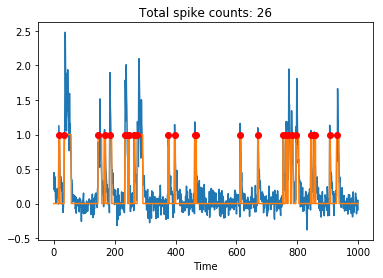

In [66]:
threshold = 0.5   # try experimenting with this

# find activity above threshold
above_thrs = (activity > threshold).astype(np.int) 

rising = (np.diff(above_thrs) > 0).astype(np.int)   # find rising edge of crossing threshold
spikes = np.hstack((0, rising))    # prepend 0 to account for shortening due to np.diff

count = spikes.sum()   # compute total spike counts


plt.plot(activity)
plt.plot(above_thrs)
plt.plot(np.where(spikes>0), 1,  'ro'); # plot only spike points
plt.xlabel('Time')
plt.title('Total spike counts: {}'.format(count));

Now notice that the exact spikes you detect depend on the value of the `threshold`. Therefore, the **`threshold` is a parameter** for our spike detection computation. Rather than fixing the value of the threshold, we might want to try different values and see what works well.

In other words, you want to compute `Spikes` for a **combination** of `Neuron`s and different `threshold` values. To do this while still taking advantage of the `make` and `populate` logic, you would want to define a table to house parameters for spike detection in a `Lookup` table!

## Parameter **Lookup** table

In DataJoint we house things like parameters in a **look up table**.

In [67]:
@schema
class SpikeDetectionParam(dj.Lookup):
    definition = """
    sdp_id: int      # unique id for spike detection parameter set
    ---
    threshold: float   # threshold for spike detection
    """

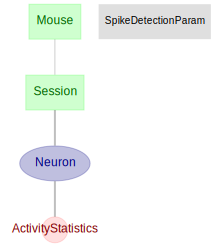

In [68]:
dj.ERD(schema)

### Defining `Spikes` table

Now let's take everything together and define the `Spikes` table. Here each entry of the table will be *a set of spikes* for a single neuron, using a particular value of the `SpikeDetectionParam`. In other words, any particular entry of the `Spikes` table is determined by **a combination of a neuron and spike detection parameters**.

We capture this by depending on both `Neuron` and `SpikeDetectionParam`. For each spike set, we want to store the detected spikes and the total number of spikes. The table definition will look something like:

In [69]:
@schema
class Spikes(dj.Computed):
    definition = """
    -> Neuron
    -> SpikeDetectionParam
    ---
    spikes: longblob     # detected spikes
    count: int           # total number of detected spikes
    """

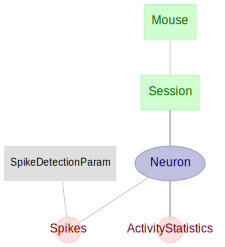

In [70]:
dj.ERD(schema)

In the ERD, we see that `Spikes` is a computed table (red circle) that depends on **both Neuron and SpikeDetectionParam**. Finally, let's go ahead and implement the `make` method for the `Spikes` table. 

In [71]:
@schema
class Spikes(dj.Computed):
    definition = """
    -> Neuron
    -> SpikeDetectionParam
    ---
    spikes: longblob     # detected spikes
    count: int           # total number of detected spikes
    """
    def make(self, key):
        print('Populating for: ', key)

        activity = (Neuron() & key).fetch1('activity')
        threshold = (SpikeDetectionParam() & key).fetch1('threshold')

        above_thrs = (activity > threshold).astype(np.int)   # find activity above threshold
        rising = (np.diff(above_thrs) > 0).astype(np.int)   # find rising edge of crossing threshold
        spikes = np.hstack((0, rising))    # prepend 0 to account for shortening due to np.diff

        count = spikes.sum()   # compute total spike counts
        print('Detected {} spikes!\n'.format(count))

        # save results and insert
        key['spikes'] = spikes
        key['count'] = count
        self.insert1(key)

The implementation of the spike detection is pretty much what we had above, except that we now fetch the value of `threshold` from the `SpikeDetectionParam` table.

Looking at the `Spikes` table, we see that it indeed inherits the primary key attributes from **both Neuron (`mouse_id`, `session_date`) and SpikeDetectionParam (`sdp_id`)**.

In [72]:
Spikes()

mouse_id Unique animal ID,session_date date,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes


### Populating `Spikes` table

We are now ready to populate! When we call `populate` on `Spikes`, DataJoint will automatically call `make` on **every valid combination of the parent tables - Neuron and SpikeDetectionParam**.

In [73]:
Spikes.populate()

Hm... `populate` doesn't seem to be doing anything... What could be the cause?

Looking at `SpikeDetectionParam` reveals the issue:

In [74]:
SpikeDetectionParam()

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection


That's right! We have not added a detection parameter set yet. Let's go ahead and add one.

In [75]:
SpikeDetectionParam.insert1((0, 0.5))

In [76]:
SpikeDetectionParam()

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection
0,0.5


Now we should really be ready to perform the computation...

In [77]:
Spikes.populate()

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'sdp_id': 0}
Detected 26 spikes!

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19), 'sdp_id': 0}
Detected 24 spikes!

Populating for:  {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5), 'sdp_id': 0}
Detected 18 spikes!



In [78]:
Spikes()

mouse_id Unique animal ID,session_date date,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes
0,2017-05-15,0,=BLOB=,26
0,2017-05-19,0,=BLOB=,24
5,2017-01-05,0,=BLOB=,18


...and we now have spike detection running!

### Trying out other parameter values

Let's see how different thresholds affect the results.

In [79]:
SpikeDetectionParam.insert1((1, 0.9))  # add another threshold

In [80]:
SpikeDetectionParam()

sdp_id unique id for spike detection parameter set,threshold threshold for spike detection
0,0.5
1,0.9


In [81]:
Spikes.populate()

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'sdp_id': 1}
Detected 27 spikes!

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 19), 'sdp_id': 1}
Detected 21 spikes!

Populating for:  {'mouse_id': 5, 'session_date': datetime.date(2017, 1, 5), 'sdp_id': 1}
Detected 14 spikes!



In [82]:
Spikes()

mouse_id Unique animal ID,session_date date,sdp_id unique id for spike detection parameter set,spikes detected spikes,count total number of detected spikes
0,2017-05-15,0,=BLOB=,26
0,2017-05-15,1,=BLOB=,27
0,2017-05-19,0,=BLOB=,24
0,2017-05-19,1,=BLOB=,21
5,2017-01-05,0,=BLOB=,18
5,2017-01-05,1,=BLOB=,14


You can see that the results of spike detection under different parameter settings can live happily next to each other, without any confusion as to what is what.

# Summary

Congratulations! You have successfully implemented a data pipeline starting with data about experimental subjects (`Mouse`), the experimental sessions (`Session`), recorded data (`Neuron`), and we even added tables for computational results (`ActivityStatistics` and `Spikes`)!

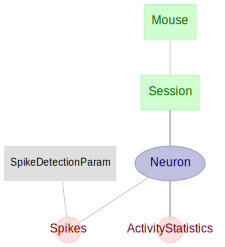

In [83]:
dj.ERD(schema)

In [86]:
for i in range(10):
    print('E')

E
E
E
E
E
E
E
E
E
E
